In [1]:
# Copyright (c) 2015-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the CC-by-NC license found in the
# LICENSE file in the root directory of this source tree.
#

'''These modules are adapted from those of timm, see
https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
'''

import torch
import torch.nn as nn
from functools import partial
import torch.nn.functional as F
from timm.models.helpers import load_pretrained
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model

import torch
import torch.nn as nn
import matplotlib.pyplot as plt


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class GPSA(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.,
                 locality_strength=1., use_local_init=True):
        super().__init__()
        self.num_heads = num_heads
        self.dim = dim
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qk = nn.Linear(dim, dim * 2, bias=qkv_bias)       
        self.v = nn.Linear(dim, dim, bias=qkv_bias)       
        
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.pos_proj = nn.Linear(3, num_heads)
        self.proj_drop = nn.Dropout(proj_drop)
        self.locality_strength = locality_strength
        self.gating_param = nn.Parameter(torch.ones(self.num_heads))
        self.apply(self._init_weights)
        if use_local_init:
            self.local_init(locality_strength=locality_strength)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        
    def forward(self, x):
        B, N, C = x.shape
        if not hasattr(self, 'rel_indices') or self.rel_indices.size(1)!=N:
            self.get_rel_indices(N)

        attn = self.get_attention(x)
        v = self.v(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def get_attention(self, x):
        B, N, C = x.shape        
        qk = self.qk(x).reshape(B, N, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k = qk[0], qk[1]
        pos_score = self.rel_indices.expand(B, -1, -1,-1)
        pos_score = self.pos_proj(pos_score).permute(0,3,1,2) 
        patch_score = (q @ k.transpose(-2, -1)) * self.scale
        patch_score = patch_score.softmax(dim=-1)
        pos_score = pos_score.softmax(dim=-1)

        gating = self.gating_param.view(1,-1,1,1)
        attn = (1.-torch.sigmoid(gating)) * patch_score + torch.sigmoid(gating) * pos_score
        attn /= attn.sum(dim=-1).unsqueeze(-1)
        attn = self.attn_drop(attn)
        return attn

    def get_attention_map(self, x, return_map = False):

        attn_map = self.get_attention(x).mean(0) # average over batch
        distances = self.rel_indices.squeeze()[:,:,-1]**.5
        dist = torch.einsum('nm,hnm->h', (distances, attn_map))
        dist /= distances.size(0)
        if return_map:
            return dist, attn_map
        else:
            return dist
    
    def local_init(self, locality_strength=1.):
        
        self.v.weight.data.copy_(torch.eye(self.dim))
        locality_distance = 1 #max(1,1/locality_strength**.5)
        
        kernel_size = int(self.num_heads**.5)
        center = (kernel_size-1)/2 if kernel_size%2==0 else kernel_size//2
        for h1 in range(kernel_size):
            for h2 in range(kernel_size):
                position = h1+kernel_size*h2
                self.pos_proj.weight.data[position,2] = -1
                self.pos_proj.weight.data[position,1] = 2*(h1-center)*locality_distance
                self.pos_proj.weight.data[position,0] = 2*(h2-center)*locality_distance
        self.pos_proj.weight.data *= locality_strength

    def get_rel_indices(self, num_patches):
        #img_size = int(num_patches**.5)
        #rel_indices   = torch.zeros(1, num_patches, num_patches, 3)
        #ind = torch.arange(img_size).view(1,-1) - torch.arange(img_size).view(-1, 1)
        #indx = ind.repeat(img_size,img_size)
        #indy = ind.repeat_interleave(img_size,dim=0).repeat_interleave(img_size,dim=1)
        #indd = indx**2 + indy**2
        #rel_indices[:,:,:,2] = indd.unsqueeze(0)
        #rel_indices[:,:,:,1] = indy.unsqueeze(0)
        #rel_indices[:,:,:,0] = indx.unsqueeze(0)
        #device = self.qk.weight.device
        #self.rel_indices = rel_indices.to(device)

        img_size = (1, 300)
        patch_size = (1, 300 // num_patches)

        num_patches_x = img_size[1] // patch_size[1]
        num_patches_y = img_size[0] // patch_size[0]

        rel_indices = torch.zeros(1, num_patches_x * num_patches_y, num_patches_x * num_patches_y, 3)
        ind = torch.arange(num_patches_x).view(1,-1) - torch.arange(num_patches_x).view(-1, 1)
        indx = ind.repeat(num_patches_y, 1).repeat(1, num_patches_y)
        ind = torch.arange(num_patches_y).view(1,-1) - torch.arange(num_patches_y).view(-1, 1)
        indy = ind.repeat_interleave(num_patches_y, dim=0).repeat_interleave(num_patches_y, dim=1)
        indd = indx**2 + indy**2
        rel_indices[:,:,:,2] = indd.unsqueeze(0)
        rel_indices[:,:,:,1] = indy.unsqueeze(0)
        rel_indices[:,:,:,0] = indx.unsqueeze(0)

        device = self.qk.weight.device
        self.rel_indices = rel_indices.to(device)

 
class MHSA(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def get_attention_map(self, x, return_map = False):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn_map = (q @ k.transpose(-2, -1)) * self.scale
        attn_map = attn_map.softmax(dim=-1).mean(0)

        img_size = int(N**.5)
        ind = torch.arange(img_size).view(1,-1) - torch.arange(img_size).view(-1, 1)
        indx = ind.repeat(img_size,img_size)
        indy = ind.repeat_interleave(img_size,dim=0).repeat_interleave(img_size,dim=1)
        indd = indx**2 + indy**2
        distances = indd**.5
        distances = distances.to('cuda')

        dist = torch.einsum('nm,hnm->h', (distances, attn_map))
        dist /= N
        
        if return_map:
            return dist, attn_map
        else:
            return dist

            
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
    
class Block(nn.Module):

    def __init__(self, dim, num_heads,  mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, use_gpsa=True, **kwargs):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.use_gpsa = use_gpsa
        if self.use_gpsa:
            self.attn = GPSA(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop, **kwargs)
        else:
            self.attn = MHSA(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop, **kwargs)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x
    

class PatchEmbed(nn.Module):
    """ Image to Patch Embedding, from timm
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.apply(self._init_weights)
    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

class HybridEmbed(nn.Module):
    """ CNN Feature Map Embedding, from timm
    """
    def __init__(self, backbone, img_size=224, feature_size=None, in_chans=3, embed_dim=768):
        super().__init__()
        assert isinstance(backbone, nn.Module)
        img_size = to_2tuple(img_size)
        self.img_size = img_size
        self.backbone = backbone
        if feature_size is None:
            with torch.no_grad():
                training = backbone.training
                if training:
                    backbone.eval()
                o = self.backbone(torch.zeros(1, in_chans, img_size[0], img_size[1]))[-1]
                feature_size = o.shape[-2:]
                feature_dim = o.shape[1]
                backbone.train(training)
        else:
            feature_size = to_2tuple(feature_size)
            feature_dim = self.backbone.feature_info.channels()[-1]
        self.num_patches = feature_size[0] * feature_size[1]
        self.proj = nn.Linear(feature_dim, embed_dim)
        self.apply(self._init_weights)

    def forward(self, x):
        x = self.backbone(x)[-1]
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=48, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm, global_pool=None,
                 local_up_to_layer=10, locality_strength=1., use_pos_embed=True, **extra):
        super().__init__()

        print("ignored params", extra)

        embed_dim *= num_heads
        self.num_classes = num_classes
        self.local_up_to_layer = local_up_to_layer
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.locality_strength = locality_strength
        self.use_pos_embed = use_pos_embed

        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone, img_size=img_size, in_chans=in_chans, embed_dim=embed_dim)
        else:
            self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        self.num_patches = num_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        if self.use_pos_embed:
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.pos_embed, std=.02)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                use_gpsa=True,
                locality_strength=locality_strength)
            if i<local_up_to_layer else
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                use_gpsa=False)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.feature_info = [dict(num_chs=embed_dim, reduction=0, module='head')]
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.cls_token, std=.02)
        self.head.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)

        if self.use_pos_embed:
            x = x + self.pos_embed
        x = self.pos_drop(x)

        for u,blk in enumerate(self.blocks):
            if u == self.local_up_to_layer :
                x = torch.cat((cls_tokens, x), dim=1)
            x = blk(x)

        x = self.norm(x)
        return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x
    
import torch
import torch.nn as nn
from functools import partial

from timm.models.efficientnet import EfficientNet
from timm.models.vision_transformer import _cfg
from timm.models.registry import register_model

@register_model
def convit_tiny(pretrained=False, **kwargs):
    num_heads = 4
    kwargs['embed_dim'] *= num_heads
    model = VisionTransformer(
        num_heads=num_heads,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            url="https://dl.fbaipublicfiles.com/convit/convit_tiny.pth",
            map_location="cpu", check_hash=True
        )
        model.load_state_dict(checkpoint)
    return model

@register_model
def convit_small(pretrained=False, **kwargs):
    num_heads = 9
    kwargs['embed_dim'] *= num_heads
    model = VisionTransformer(
        num_heads=num_heads,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            url="https://dl.fbaipublicfiles.com/convit/convit_small.pth",
            map_location="cpu", check_hash=True
        )
        model.load_state_dict(checkpoint)
    return model

@register_model
def convit_base(pretrained=False, **kwargs):
    num_heads = 16
    kwargs['embed_dim'] *= num_heads
    model = VisionTransformer(
        num_heads=num_heads,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            url="https://dl.fbaipublicfiles.com/convit/convit_base.pth",
            map_location="cpu", check_hash=True
        )
        model.load_state_dict(checkpoint)
    return model

ignored params {}


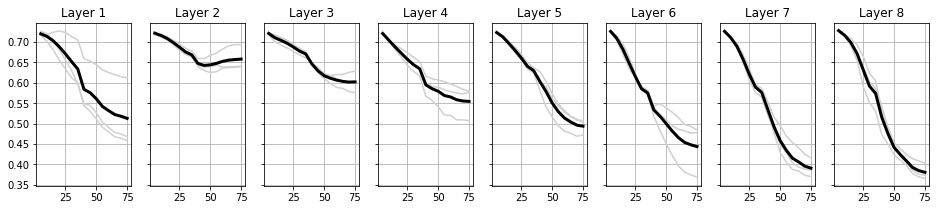

[False  True  True  True False False False False]
ignored params {}


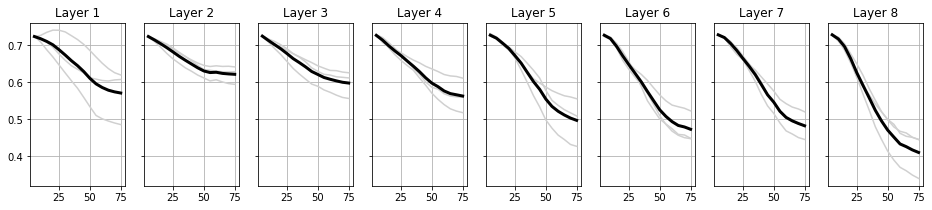

[ True  True  True  True False False False False]
ignored params {}


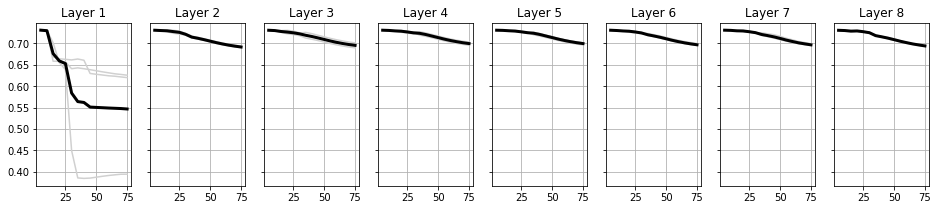

[False  True  True  True  True  True  True  True]
ignored params {}


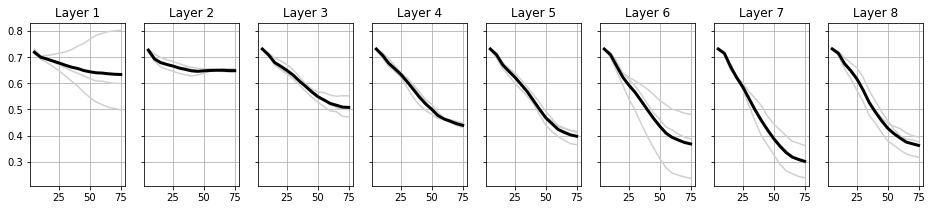

[ True  True  True False False False False False]
ignored params {}


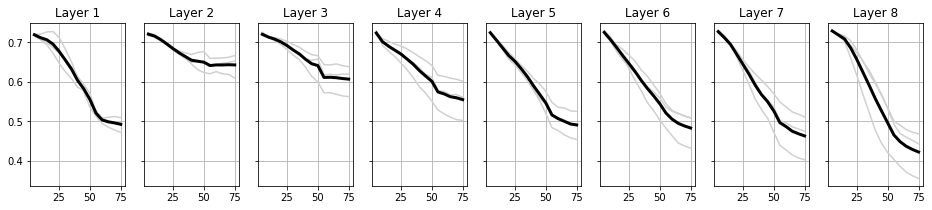

[False  True  True  True False False False False]
ignored params {}


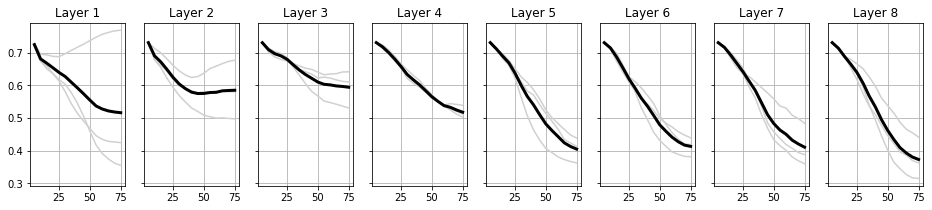

[ True  True  True  True False False False False]
ignored params {}


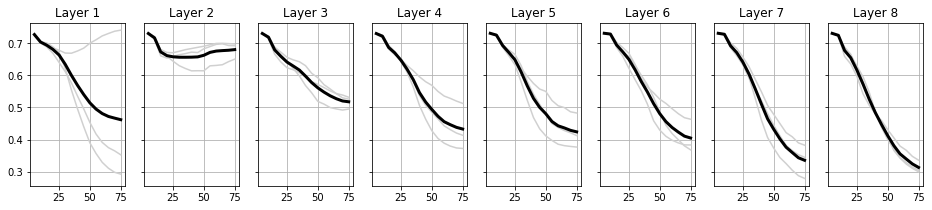

[False  True  True False False False False False]
ignored params {}


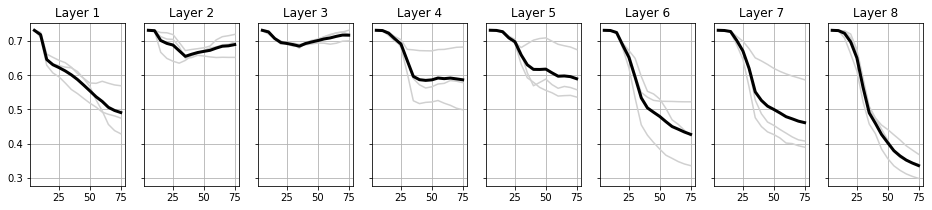

[False  True  True  True  True False False False]
ignored params {}


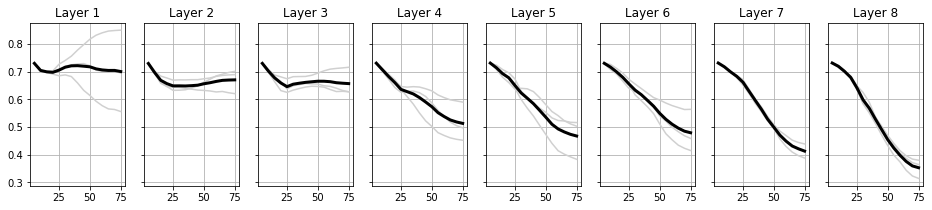

[ True  True  True False False False False False]
ignored params {}


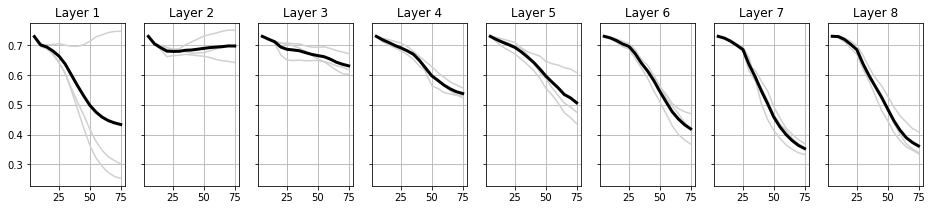

[False  True  True  True False False False False]


In [80]:
epochs = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
for subject in range(10):
    convit = VisionTransformer(img_size=(1, 300), patch_size=(1, 10), in_chans=14, num_classes=8, embed_dim=32, depth=8,
                 num_heads=3, mlp_ratio=2., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm, global_pool=None,
                 local_up_to_layer=10, locality_strength=1., use_pos_embed=True)

    localities = [[] for i in range(len(convit.blocks))]
    
    for epoch in epochs:
        convit.load_state_dict(torch.load(f'convit_{subject}_1_epoch{epoch}.pth', map_location=torch.device('cpu')))
        convit.eval()
        for layer in range(len(convit.blocks)):
            localities[layer].append(torch.sigmoid(convit.blocks[layer].attn.gating_param).detach().numpy())

    import numpy as np
    import matplotlib.pyplot as plt

    gating_epochs = np.transpose(np.array(localities), (0, 2, 1))

    fig, ax = plt.subplots(figsize=(2 * gating_epochs.shape[0], 3), ncols=gating_epochs.shape[0], sharey=True)
    for i in range(gating_epochs.shape[0]):
        for ii in range(gating_epochs.shape[1]):
            ax[i].plot(epochs, gating_epochs[i][ii], c='#D0D0D0')
        ax[i].plot(epochs, gating_epochs[i].mean(axis=0), c='#000000', linewidth=3.0)
        ax[i].set_title(f'Layer {i + 1}')
        ax[i].grid('on')
    plt.show()
    
    #print(gating_epochs.mean(axis=1)[:, -1] > .5)
    v = gating_epochs.mean(axis=1)[:, -1]
    max, min = v.max(), v.min()
    print((v -min) / (max-min) > .5)
    

In [83]:
epochs = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
conv_layers = []
for subject in range(10):
    convit = VisionTransformer(img_size=(1, 300), patch_size=(1, 10), in_chans=14, num_classes=8, embed_dim=32, depth=8,
                 num_heads=3, mlp_ratio=2., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm, global_pool=None,
                 local_up_to_layer=10, locality_strength=1., use_pos_embed=True)

    localities = [[] for i in range(len(convit.blocks))]
    
    for epoch in epochs:
        convit.load_state_dict(torch.load(f'convit_{subject}_1_epoch{epoch}.pth', map_location=torch.device('cpu')))
        convit.eval()
        for layer in range(len(convit.blocks)):
            localities[layer].append(torch.sigmoid(convit.blocks[layer].attn.gating_param).detach().numpy())

    gating_epochs = np.transpose(np.array(localities), (0, 2, 1))
    v = gating_epochs.mean(axis=1)[:, -1]
    max, min = v.max(), v.min()
    conv_layers.append([a for a in np.arange(8)[(v -min) / (max-min) > .5]])

ignored params {}
ignored params {}
ignored params {}
ignored params {}
ignored params {}
ignored params {}
ignored params {}
ignored params {}
ignored params {}
ignored params {}


In [84]:
conv_layers

[[1, 2, 3],
 [0, 1, 2, 3],
 [1, 2, 3, 4, 5, 6, 7],
 [0, 1, 2],
 [1, 2, 3],
 [0, 1, 2, 3],
 [1, 2],
 [1, 2, 3, 4],
 [0, 1, 2],
 [1, 2, 3]]

In [82]:
conv_layers

[[0, 1, 2, 3],
 [0, 1, 2, 3],
 [0, 1, 2, 3, 4, 5, 6, 7],
 [0, 1, 2],
 [1, 2, 3],
 [0, 1, 2, 3],
 [1, 2],
 [1, 2, 3, 4],
 [0, 1, 2, 3],
 [1, 2, 3, 4]]

In [30]:
def attention_head(n_tokens, dim, dim_head):
    macs = 0
    
    # token -> k, q, v
    macs += n_tokens * 3 * dim * dim_head
    
    # q * k'
    # (n_tokens, dim_head) * (dim_head, n_tokens) -> (n_tokens, n_tokens)
    macs += n_tokens * dim_head * n_tokens
    
    # Softmax e diviso sqrt(dim_head) 
    # ...
    
    # (q * k') * v
    # (n_tokens, n_tokens) * (n_tokens, dim_head) -> (n_tokens, dim_head)
    macs += n_tokens * n_tokens * dim_head
    
    return macs
    
def attention(n_tokens, dim, dim_head, n_heads):
    macs = 0
    
    macs += n_heads * attention_head(n_tokens, dim, dim_head)
    
    # Riporta gli z concatenati a dimensione dim
    macs += n_tokens * (dim_head * n_heads) * dim if not (n_heads == 1 and dim_head == dim) else 0
    
    return macs

def feed_forward(n_tokens, dim, mlp_dim):
    # 2 Linear: dim -> mlp_dim, mlp_dim -> dim
    return n_tokens * dim * mlp_dim * 2

def transformer(n_tokens, dim, dim_head, n_heads, mlp_dim, depth):
    return depth * (attention(n_tokens, dim, dim_head, n_heads) + feed_forward(n_tokens, dim, mlp_dim))

def vit(patch_size, dim, dim_head, n_heads, mlp_dim, depth):
    macs = 0
    
    n_tokens = 300 // patch_size
    
    # linear embedding
    macs += n_tokens * (14 * patch_size) * dim
    
    # +1 perché c'è cls_token
    macs += transformer(n_tokens + 1, dim, dim_head, n_heads, mlp_dim, depth)
    
    # output
    # Da mean o last token a class_scores
    macs += dim * 8
    
    return macs

import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)
               
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        qkv = qkv.chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0., use_cls_token=True):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        #self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.use_cls_token = use_cls_token
        if self.use_cls_token:
            self.pos_embedding = nn.Parameter(torch.empty(1, num_patches + 1, dim))
        else:
            self.pos_embedding = nn.Parameter(torch.empty(1, num_patches, dim))
        #nn.init.kaiming_uniform_(self.pos_embedding, a=5 ** .5)
        nn.init.normal_(self.pos_embedding, std=.02)

        #self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.cls_token = nn.Parameter(torch.empty(1, 1, dim))
        nn.init.zeros_(self.cls_token)
        
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        # MACs: patch_size * n_patches * dim, es (30 * 14) * 10 * 300
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        
        if self.use_cls_token:
            cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
            x = torch.cat((cls_tokens, x), dim=1)
            x += self.pos_embedding[:, :(n + 1)]
        else :
            x += self.pos_embedding
        
        x = self.dropout(x)
        
        # FeedForward    Attention       project out
        # 300*300*10*2 + 300*(64*3)*10 + ((64)*300*10)
        # Attention -> manca softmax e attention vera e propria, c'è solo linear encoding a qkv
        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        
        x = self.to_latent(x)
        x = self.mlp_head(x)
        return x
    
# Ratio of params
def vit_aff_ratio(patch_size, dim, dim_head, n_heads, mlp_dim, depth): 
    n_tokens = 300 // patch_size + 1
    
    a = (((dim) * dim_head * 3 * n_heads) + ((dim_head * n_heads) * dim) + dim)
    ff = dim * mlp_dim * 2 + mlp_dim + dim
    
    return a / (a + ff)

def get_results(configs, results_, additional_columns, extract_model_hparams):
        
    acccs = []
    acccs_steady = []
    acccs_val0 = []
    acccs_steady_val0 = []
    acccs_val1 = []
    acccs_steady_val1 = []

    acccs_val_val0 = 0
    acccs_val_val1 = 0
    acccs_train_val0 = 0
    acccs_train_val1 = 0
    
    acccs_steady_persubject = np.array([0] * 10, dtype=float)
    preds_steady_bincounts_subject = np.zeros((10, 8), dtype=int)
    
    for config, r in zip(configs, results_):

        accs = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds'], r['val-fold_0']['y_trues'])):
            accs[i] += (y_pred == y_true).sum().float() / len(y_true)
        #for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds'], r['val-fold_1']['y_trues'])):
        #    accs[i] += (y_pred == y_true).sum().float() / len(y_true)
        #accs /= 2

        accs_steady = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds_steady'], r['val-fold_0']['y_trues_steady'])):
            accs_steady[i] += (y_pred == y_true).sum().float() / len(y_true)
        #for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds_steady'], r['val-fold_1']['y_trues_steady'])):
        #    accs_steady[i] += (y_pred == y_true).sum().float() / len(y_true)
        #accs_steady /= 2

        accs_val0 = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds'], r['val-fold_0']['y_trues'])):
            accs_val0[i] += (y_pred == y_true).sum().float() / len(y_true)

        accs_steady_val0 = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds_steady'], r['val-fold_0']['y_trues_steady'])):
            accs_steady_val0[i] += (y_pred == y_true).sum().float() / len(y_true)
            acccs_steady_persubject[r['subject'] - 1] += (y_pred == y_true).sum().float() / len(y_true)
            preds_steady_bincounts_subject[r['subject'] - 1] += y_pred.bincount(minlength=(y_true.max() + 1)).numpy()
            
        accs_val1 = np.array([0] * len(r['test_sessions']), dtype=float)
        #for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds'], r['val-fold_1']['y_trues'])):
        #    accs_val1[i] += (y_pred == y_true).sum().float() / len(y_true)

        accs_steady_val1 = np.array([0] * len(r['test_sessions']), dtype=float)
        #for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds_steady'], r['val-fold_1']['y_trues_steady'])):
        #    accs_steady_val1[i] += (y_pred == y_true).sum().float() / len(y_true)
        #    acccs_steady_persubject[r['subject'] - 1] += (y_pred == y_true).sum().float() / len(y_true)
        #    preds_steady_bincounts_subject[r['subject'] - 1] += y_pred.bincount(minlength=(y_true.max() + 1)).numpy()
            
        acccs_train_val0 += r['val-fold_0']['losses_accs'][-1]['train_acc']
        #acccs_train_val1 += r['val-fold_1']['losses_accs'][-1]['train_acc']

        acccs_val_val0 += r['val-fold_0']['losses_accs'][-1]['val_acc']
        #acccs_val_val1 += r['val-fold_1']['losses_accs'][-1]['val_acc']

        acccs.append(accs)
        acccs_steady.append(accs_steady)
        acccs_val0.append(accs_val0)
        acccs_steady_val0.append(accs_steady_val0)
        acccs_val1.append(accs_val1)
        acccs_steady_val1.append(accs_steady_val1)
        
    test_sessions = len(r['test_sessions'])

    acccs_steady_persubject /= test_sessions #* 2 # 5 sessioni per due

    acccs = np.array(acccs).mean(axis=0)

    acccs_steady_ = np.array(acccs_steady).mean(axis=1)
    acccs_steady = np.array(acccs_steady).mean(axis=0)

    acccs_val0 = np.array(acccs_val0).mean(axis=0)
    acccs_val1 = np.array(acccs_val1).mean(axis=0)
    acccs_steady_val0 = np.array(acccs_steady_val0).mean(axis=0)
    acccs_steady_val1 = np.array(acccs_steady_val1).mean(axis=0)
    acccs_val_val0 /= 10
    acccs_val_val1 /= 10
    acccs_train_val0 /= 10
    acccs_train_val1 /= 10
    
    model_hparams = extract_model_hparams(config)

    return {        
        **model_hparams,

        **additional_columns,

        "train accuracy steady fold1":  acccs_train_val0,
        "train accuracy steady fold2":  acccs_train_val1,
        "train accuracy steady avg2folds": .5 * (acccs_train_val0 + acccs_train_val1),

        "validation accuracy steady fold1": acccs_val_val0,
        "validation accuracy steady fold2": acccs_val_val1,

        "test accuracy fold1": acccs_val0.mean(),
        "test accuracy fold2": acccs_val1.mean(),
        "test accuracy avg2folds": acccs.mean(), 
        "test accuracy steady fold1": acccs_steady_val0.mean(),
        "test accuracy steady fold2": acccs_steady_val1.mean(), 
        "test accuracy steady avg2folds": acccs_steady.mean(),

        "test accuracy steady avg2folds std across sessions": acccs_steady.std(),
        "test accuracy steady avg2folds std across subjects": acccs_steady_.std(),
        
        **{
          f"test accuracy steady session{s + 1 + test_sessions} avg2folds": acccs_steady[s] for s in range(test_sessions)
        },
        
        **{
            f"test accuracy steady subj{s} avg2folds": acccs_steady_persubject[s] for s in range(10)
        },
        
        **{
            f"test preds steady subj{s} avg2folds": preds_steady_bincounts_subject[s] for s in range(10)
        },
    }

from pickle import load

import numpy as np
import pandas as pd

def group_configs(configs, group_exclude_columns):
    # https://stackoverflow.com/a/6027615
    import collections.abc

    def flatten(d, parent_key='', sep='_'):
        items = []
        for k, v in d.items():
            new_key = parent_key + sep + k if parent_key else k
            if isinstance(v, collections.abc.MutableMapping):
                items.extend(flatten(v, new_key, sep=sep).items())
            else:
                items.append((new_key, v))
        return dict(items)

    df = pd.DataFrame([flatten(config) for config in configs])
    df['row_id'] = [[a] for a in df.index]
    
    if 'training_config_lr_scheduler_hparams_milestones' in df:
        df['training_config_lr_scheduler_hparams_milestones'] = df['training_config_lr_scheduler_hparams_milestones'].apply(lambda x: ','.join(map(str, x)))
    df = df.fillna('null')
    
    grouped_configs = df.groupby([c for c in df.columns if c not in group_exclude_columns]).agg({'subjects': 'count', 'row_id': 'sum'})
    
    if (grouped_configs['subjects'] != 10).sum() != 0:
        display(grouped_configs)
        raise ValueError("For every config, it is assumed that you trained on 10 subjects")
    
    return list(grouped_configs["row_id"])


extract_model_hparams_generator = {
    'vit': lambda config: {
        "window_size": config["image_size"][1],
        "patch_size": config["patch_size"][1],
        "dim_projection": config["dim"],
        "dim_ff": config["mlp_dim"],
        "dim_head": config["dim_head"],
        "n_heads": config["heads"],
        "depth": config["depth"],
        "dropout": config["dropout"],
        "emb_dropout": config["emb_dropout"],
        
        "MACs": vit(patch_size=config["patch_size"][1], dim=config["dim"], dim_head=config["dim_head"], n_heads=config["heads"], mlp_dim=config["mlp_dim"], depth=config["depth"]),
        "params":  sum([param.nelement() for param in ViT(image_size=(1, 300), patch_size=config["patch_size"], dim=config["dim"], dim_head=config["dim_head"], heads=config["heads"], mlp_dim=config["mlp_dim"], depth=config["depth"], num_classes=8).parameters()]),
        "params_aff_ratio": vit_aff_ratio(patch_size=config["patch_size"][1], dim=config["dim"], dim_head=config["dim_head"], n_heads=config["heads"], mlp_dim=config["mlp_dim"], depth=config["depth"]),
        
    },
    'temponet': lambda _: {
        "MACs": 16028672,
        "params": 461512,
    },
    "convit": lambda _: {}
}

def read_results(filename, additional_columns=None, group_exclude_columns=None, model_name='vit'):
    additional_columns = {} if additional_columns is None else additional_columns
    
    group_exclude_columns = set() if group_exclude_columns is None else group_exclude_columns
    group_exclude_columns = group_exclude_columns.union({'subjects', 'row_id'})
    
    configs, results_ = load(open(filename, 'rb'))
    
    groups_indices = group_configs(configs, group_exclude_columns)
    
    df_l = []
    for idx in groups_indices:
        c = [configs[i] for i in idx]
        r = [results_[i] for i in idx]
        
        df_l.append(get_results(c, r, additional_columns, extract_model_hparams_generator[model_name]))   
    
    return pd.DataFrame(df_l) 

def get_rows(all_res_vit, group):
    m = None
    for k in group.keys():
        current_m = all_res_vit[k] == group[k]
        if m is None:
            m = current_m
        else:
            m &= current_m
    return all_res_vit[m].copy()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [33]:
df = read_results("results_1631050732.pickle", model_name='convit')

In [38]:
df[[f"test accuracy steady subj{i} avg2folds" for i in range(10) if i != 2]].iloc[0].mean()

0.6342636161380344